# CNS spring-block simulations

In this tutorial, we'll run a series of spring-block (1D fault) simulations with the _Chen-Niemeijer-Spiers_ (CNS) microphysical model. We start by importing the necessary libraries:

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
# Go up in the directory tree
upup = [os.pardir]*2
qdyn_dir = os.path.join(*upup)
# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "src")
)
# Append src directory to Python path
sys.path.append(src_dir)

# Import QDYN wrapper
from pyqdyn import qdyn

The simulation parameters are accessible after instantiation of the QDYN class as a Python dictionary object. We first define a number of global simulation parameters:

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Get the settings dict
set_dict = p.set_dict

# Global simulation parameters
set_dict["MESHDIM"] = 0        # Simulation dimensionality (spring-block)
set_dict["TMAX"] = 200         # Maximum simulation time [s]
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["V_PL"] = 1e-5        # Load-point velocity [m/s]
set_dict["MU"] = 2e9           # Shear modulus [Pa]
set_dict["VS"] = 0             # Turn of radiation damping
set_dict["SIGMA"] = 5e6        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# To switch from rate-and-state friction ("RSF"; default) to the CNS model,
# we set the "FRICTION_MODEL" to "CNS"
set_dict["FRICTION_MODEL"] = "CNS"

We then overwrite the default values of specific rheological parameters:

In [3]:
set_dict["SET_DICT_CNS"]["H"] = 0.5        # Dilatancy coefficient (higher = more dilatancy)
set_dict["SET_DICT_CNS"]["PHI_C"] = 0.3    # Critical state (maximum) porosity
set_dict["SET_DICT_CNS"]["A"] = [1e-10]    # Kinetic parameter of the creep mechanism
set_dict["SET_DICT_CNS"]["N"] = [1]        # Stress exponent of the creep mechanism

# Thickness of the (localised) gouge layer [m]
set_dict["SET_DICT_CNS"]["THICKNESS"] = 1e-4
# Initial shear stress [Pa]
set_dict["SET_DICT_CNS"]["TAU"] = 0.5 * set_dict["SIGMA"]
# Initial porosity [-]
set_dict["SET_DICT_CNS"]["PHI_INI"] = 0.25

Lastly, we pass the settings to the QDYN wrapper, generate the mesh (only 1 element) and write the `qdyn.in` input file:

In [4]:
p.settings(set_dict)
p.render_mesh()
p.write_input()

True

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

In [5]:
p.run()

0

The simulation output is read and processed by the wrapper using:

In [6]:
p.read_output()

True

The simulation time series output is then stored as a pandas `DataFrame` in `p.ot`. To inspect the first 10 entries:

In [7]:
p.ot[0].head(10)

,t,potcy,pot_rate,v,theta,tau,dtau_dt,slip,sigma
0,0.000000,0.000000e+00,9.002004e-07,9.002004e-07,0.250000,2500000.0,0.0,0.000000e+00,5000000.0
1,0.080798,7.191950e-08,8.802334e-07,8.802334e-07,0.249421,2501472.0,0.0,7.191950e-08,5000000.0
2,0.325054,2.801880e-07,8.266678e-07,8.266678e-07,0.247763,2505941.0,0.0,2.801880e-07,5000000.0
3,0.678299,5.605904e-07,7.632935e-07,7.632935e-07,0.245567,2512445.0,0.0,5.605904e-07,5000000.0
4,1.151055,9.050390e-07,6.967863e-07,6.967863e-07,0.242930,2521211.0,0.0,9.050390e-07,5000000.0
5,1.765096,1.311767e-06,6.311149e-07,6.311149e-07,0.239899,2532678.0,0.0,1.311767e-06,5000000.0
6,2.562229,1.788364e-06,5.679468e-07,5.679468e-07,0.236458,2547668.0,0.0,1.788364e-06,5000000.0
7,3.610427,2.350472e-06,5.079562e-07,5.079562e-07,0.232549,2567508.0,0.0,2.350472e-06,5000000.0
8,5.032942,3.029962e-06,4.509232e-07,4.509232e-07,0.228034,2594599.0,0.0,3.029962e-06,5000000.0
9,7.137065,3.915270e-06,3.946646e-07,3.946646e-07,0.222478,2634911.0,0.0,3.915270e-06,5000000.0


To see the behaviour of our spring-block fault, we can plot the time series of (normalised) shear stress, porosity, and slip velocity:

<IPython.core.display.Javascript object>


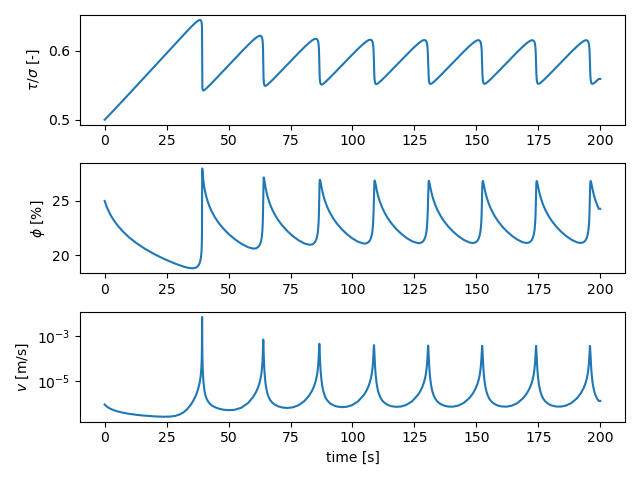

In [8]:
plt.figure()

# Normalised shear stress
plt.subplot(311)
plt.plot(p.ot[0]["t"], p.ot[0]["tau"] / set_dict["SIGMA"])
plt.ylabel(r"$\tau / \sigma$ [-]")

# Porosity
plt.subplot(312)
plt.plot(p.ot[0]["t"], 100 * p.ot[0]["theta"])
plt.ylabel(r"$\phi$ [%]")

# Velocity
plt.subplot(313)
plt.plot(p.ot[0]["t"], p.ot[0]["v"])
plt.yscale("log")
plt.ylabel(r"$v$ [m/s]")
plt.xlabel("time [s]")

plt.tight_layout()
plt.show()

Note that the stick-slip cycles converge to a stable limit cycle, even in the absence of radiation damping. This is in contrast to classical rate-and-state friction, which does not exhibit stable limit cycles.

The stability of a fault governed by CNS rheology is very sensitive to the granular flow parameters, such as the dilatancy parameter $H$ (see _van den Ende et al._ , [2018](https://doi.org/10.1016/j.tecto.2017.11.040)). By changing this value from 0.5 to 0.3, the fault stabilises at only deforms at steady-state:

<IPython.core.display.Javascript object>


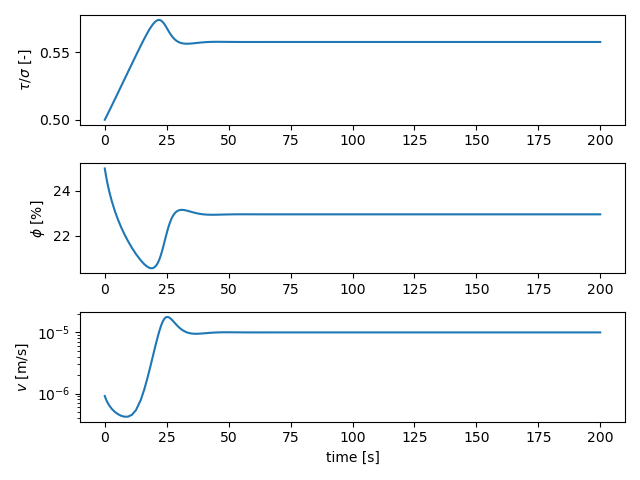

In [9]:
set_dict["SET_DICT_CNS"]["H"] = 0.3        # Updated dilatancy coefficient

# Write settings, run simulation
p.settings(set_dict)
p.render_mesh()
p.write_input()
p.run()
p.read_output()

# Plot time series
plt.figure()
plt.subplot(311)
plt.plot(p.ot[0]["t"], p.ot[0]["tau"] / set_dict["SIGMA"])
plt.ylabel(r"$\tau / \sigma$ [-]")

plt.subplot(312)
plt.plot(p.ot[0]["t"], 100 * p.ot[0]["theta"])
plt.ylabel(r"$\phi$ [%]")

plt.subplot(313)
plt.plot(p.ot[0]["t"], p.ot[0]["v"])
plt.yscale("log")
plt.ylabel(r"$v$ [m/s]")
plt.xlabel("time [s]")

plt.tight_layout()
plt.show()